In [3]:
# Imports
import re
import urllib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

import pandas as pd

# Sentiment analysis

The file *tweets.txt* contains tweets by users about movies, organized by line (each line in the file is a different tweet). In the *labels.txt*, for each tweet we have a label (positive/negative).

We want to find out if the tweet is positive or negative.
Let's try to train a rnn for tweets classification.


## Preparing the datasets
First of all, we have to prepare our datasets.

### Reading the files and converting them into Tensors

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
#cd /content/drive/MyDrive/TwitterSentimentDataset

In [8]:
data= pd.read_csv("C://users/noemi/Desktop/SentimentAnalysisTwitter/train.csv")

In [9]:
#data_for_label = pd.read_csv("C://users/noemi/Desktop/SentimentAnalysisTwitter/train.csv")

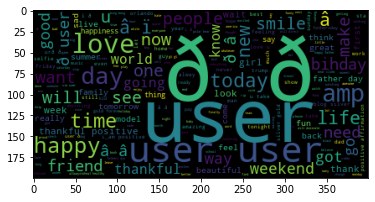

In [10]:
#conda install -c https://conda.anaconda.org/conda-forge wordcloud
from wordcloud import WordCloud
sentences = data['tweet'].tolist()
combined_sentences = " ".join(sentences)
plt.imshow(WordCloud().generate(combined_sentences))
plt.show()

In [11]:
!pip install nlpaug
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
#import textblob
#from textblob import TextBlob, Word
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import os

In [12]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [13]:
TARGET='label'
data['label'].value_counts()
#data_for_label = data
#it is unbalanced data as we could see there is only 7% which accounts positive class while rest are negative class

0    29720
1     2242
Name: label, dtype: int64

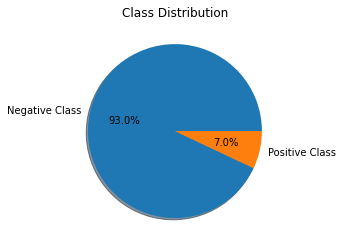

In [15]:
plt.pie(data['label'].value_counts(), autopct='%1.1f%%', shadow=True,labels=['Negative Class','Positive Class'])
plt.title('Class Distribution');
plt.show()
import nlpaug.augmenter.sentence as nas
#You can give your own api key

WANDB_API_KEY='sonu'
#!pip install transformers

In [32]:
tweets = str()

regex = re.compile('[^a-zA-Z0-9- ]')
#First parameter is the replacement, second parameter is your input string
#
for key in data['tweet']:
  result = regex.sub('', key)
  tweets = result + '\n' + tweets 

#print(tweets)

In [33]:
type(tweets)

str

In [34]:
#test_x

In [35]:
tweets[1]

'h'

In [36]:
len(tweets)

2468243

In [37]:
# print the first 50 characters of this string
tweets[:50]

'thank you user for you follow  \nuser sikh temple v'

Now, we have to remove all puntuaction simbols inside the sentences. 

In [38]:
# Remove punctuaction
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
list_characters = [c for c in tweets if c not in punctuation]

In [40]:
len(tweets) - len(list_characters)

3078

In [41]:
tweets = "".join(list_characters)

In [42]:
tweets[:1000]

'thank you user for you follow  \nuser sikh temple vandalised in in calgary wso condemns  act  \nlistening to sad songs on a monday morning otw to work is sad  \n  to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm shame imwithher\nate user isz that youuu \noff fishing tomorrow user carnt wait first time in 2 years  \nless than 2 weeks  user ibizabringitonmallorcaholidayssummer  \nholiday   bull up you will dominate your bull and you will direct it whatever you want it to do when you \ngood morning instagram shower water berlin berlincitygirl   girl newyork zrich genf bern \nuser you went too far with user  \nive just posted a new blog secondlife lonely neko   \n user you can try to tail us to stop butt were just having too good of a time  goldenretriever   animals \nhear one of my new songs dont go  katie ellie youtube original music song relationship songwriter    \n makes you ask yourself who am i then am i anybody until go

In [43]:
len(result)

31

In [44]:
#tweets

In [45]:
# split the tweets
tweets = tweets.split("\n")

now `tweets` is a list of sentences:

In [46]:
# each element of tweets is a tweet
tweets[1]

'user sikh temple vandalised in in calgary wso condemns  act  '

In [47]:
len(tweets)

31963

In [48]:
#last elem in tweets list is an empty string, so discard it
print(tweets[4483])
tweets = tweets[:-1]

when i order a mars mcflurry i expect a mars mcflurry not mars good job my gf isnt allergic to biscuit mcdonalds   user


In [49]:
len(tweets)

31962

Since the input of our model will be the individual word, now we have to split the words inside the sentence

In [50]:
tweets = [[w for w in r.split(" ") if len(w)>0] for r in tweets]

now `tweets` is a list of list. Each reaview is a list of words.

In [51]:
tweets[0]

['thank', 'you', 'user', 'for', 'you', 'follow']

In [52]:
# compute the length of each tweet
tweets_lens = [len(r) for r in tweets]
# print the lenght of the first x tweets
tweets_lens[:10]

[6, 10, 13, 23, 5, 11, 6, 21, 12, 7]

In [53]:
# print the average tweet lenght
sum(tweets_lens) / len(tweets_lens)

12.660377948814217

Our rnn cannot use words directly, we have to convert each word in a number. When we pass a tweet to the model, the model will see a sequence of numbers.
To do this, let's create the vocabulary of our words.

In [54]:
# build vocabulary
words = list(set([w for r in tweets for w in r]))
vocab = {words[i]: i+1 for i in range(len(words))} # we reserve i=0 for pad sequences

In [55]:
len(vocab)

41501

In [56]:
#vocab
#tweets

In [57]:
# Convert tweets to word indexes
tweets = [[vocab[w] for w in r] for r in tweets]

In [58]:
tweets[0]

[22395, 1307, 6825, 29130, 1307, 39127]

In [59]:
words[4000-1]

'mourinho'

The tweets have different lengths, while, we want that all tweets have the same length


In [60]:
seq_len = 10

In [61]:
# Clip tweets to max seq_len words
tweets = [r[:seq_len] for r in tweets]

In [62]:
# Print average tweet length now
tweet_lens = [len(r) for r in tweets]
print(sum(tweet_lens)/len(tweet_lens))

8.942619360490582


In [63]:
# Pad tweets shorter than seq_len
# TODO test padding at the end
tweets = [[0]*(seq_len - len(r)) + r for r in tweets]

In [64]:
# Print average tweet length now
tweet_lens = [len(r) for r in tweets]
print(sum(tweet_lens)/len(tweet_lens))

10.0


Now, `tweets` is a list of list; each elem of `tweets` is a list with `seq_len` elements. So we can convert `tweets` in a Tensor:


In [65]:
# Convert tweets to tensor

data = torch.LongTensor(tweets)

In [66]:
data.size()

torch.Size([31962, 10])

Finally the data tensor is ready. Now it's the turn of the labels.


In [67]:
data_for_label = pd.read_csv("C://users/noemi/Desktop/SentimentAnalysisTwitter/train.csv")

In [68]:
sentiments = list()
#sentiments = sentiments[:-1]
#for key in data_for_label['label'], -1:
for key in data_for_label['label']:
  sentiments.append(key)
  #sentiments.reverse()


#print(sentiments[:-1]) #31962
#print(sentiments[:49000])

In [69]:
#sentiments = sentiments[:0]
#inversione labels
sentiments=sentiments[-1::-1]
#print(sentiments)

In [70]:
len(sentiments)

31962

In [71]:
sentiments[:10]

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [72]:
# Convert sentiments to tensor
labels = torch.LongTensor(sentiments)

In [73]:
labels.size()

torch.Size([31962])

In [74]:
data[0]

tensor([    0,     0,     0,     0, 22395,  1307,  6825, 29130,  1307, 39127])

In [75]:
labels[0]

tensor(0)

In [76]:
data.shape

torch.Size([31962, 10])

In [77]:
labels.shape

torch.Size([31962])

### Defining the Datasets

In [78]:
# some parameters
batch_size = 64

In [79]:
ones_subset = data[labels==1]
zeros_subset = data[labels== 0]

In [80]:
ones_subset.shape

torch.Size([2242, 10])

In [81]:
zeros_subset.shape

torch.Size([29720, 10])

In [82]:
ones_test_x = ones_subset[:400]
ones_val_x = ones_subset[400:600]
ones_train_x = ones_subset[600:]
ones_test_y = torch.ones(ones_test_x.shape[0])
ones_val_y = torch.ones(ones_val_x.shape[0])
ones_train_y = torch.ones(ones_train_x.shape[0])

In [83]:
ones_test_x.shape

torch.Size([400, 10])

In [84]:
ones_test_y.shape

torch.Size([400])

In [85]:
len(ones_test_x)

400

In [86]:
zeros_test_x = zeros_subset[:400]
zeros_val_x = zeros_subset[400:600]
zeros_train_x = zeros_subset[600:]
zeros_test_y = torch.zeros(zeros_test_x.shape[0])
zeros_val_y = torch.zeros(zeros_val_x.shape[0])
zeros_train_y = torch.zeros(zeros_train_x.shape[0])

In [87]:
test_x = torch.cat([ones_test_x, zeros_test_x])
test_y = torch.cat([ones_test_y, zeros_test_y])

In [88]:
test_x.shape

torch.Size([800, 10])

In [89]:
test_y.shape

torch.Size([800])

In [90]:
#test_dataset = TensorDataset(test_x, test_y)

In [91]:
val_x = torch.cat([ones_val_x, zeros_val_x])
val_y = torch.cat([ones_val_y, zeros_val_y])

In [92]:
val_x.shape

torch.Size([400, 10])

In [93]:
val_y.shape

torch.Size([400])

In [94]:
train_x = torch.cat([ones_train_x, zeros_train_x])
train_y = torch.cat([ones_train_y, zeros_train_y])

In [95]:
train_x.shape

torch.Size([30762, 10])

In [96]:
train_y.shape

torch.Size([30762])

In [97]:
test_x=torch.tensor(test_x, dtype=torch.long)
test_y=torch.tensor(test_y, dtype=torch.long)
val_x=torch.tensor(val_x, dtype=torch.long)
val_y=torch.tensor(val_y, dtype=torch.long)
train_x=torch.tensor(train_x, dtype=torch.long)
train_y=torch.tensor(train_y, dtype=torch.long)

<ipython-input-97-d0a091d51cc5>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_x=torch.tensor(test_x, dtype=torch.long)
<ipython-input-97-d0a091d51cc5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y=torch.tensor(test_y, dtype=torch.long)
<ipython-input-97-d0a091d51cc5>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_x=torch.tensor(val_x, dtype=torch.long)
<ipython-input-97-d0a091d51cc5>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detac

In [98]:
# create datasets
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

In [99]:
#tweets

In [100]:
# print the first elem of train dataset and its label
print(train_dataset[0])

(tensor([ 6825,  6825,  6825, 32915, 35428, 17970, 38435, 29130, 35848,  4600]), tensor(1))


In [101]:
# Create loaders
loaders = {"train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  drop_last=True),
           "val":   DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, drop_last=False),
           "test":  DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)}

## Defining our RNN

The [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module:

Basically, the Embedding module translates numbers in vectors. The *translation function* is learned by this module during the training. 

In [102]:
import re
import urllib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt

import pandas as pd

In [103]:
test_embedding = nn.Embedding(5, 10)

In [104]:
# example input to embedding: a batch with 2 elements, each elem has length 3
input = torch.LongTensor([[3, 2, 1],[2, 3, 1]])
input.shape

torch.Size([2, 3])

In [105]:
# Print embedding size
output = test_embedding(input)

In [106]:
output 

tensor([[[ 0.4877,  2.2494,  0.7388, -1.1016, -0.5980,  0.9204,  1.8871,
          -0.2858, -1.7517, -0.3942],
         [ 1.3854, -0.2164, -0.3017,  0.3778,  1.4639,  1.6626,  0.5082,
          -0.7074, -0.8840, -0.9965],
         [-0.1297, -0.6270,  0.1202,  2.0986,  0.1806,  0.7091,  0.8254,
          -0.9772, -1.2492,  0.2362]],

        [[ 1.3854, -0.2164, -0.3017,  0.3778,  1.4639,  1.6626,  0.5082,
          -0.7074, -0.8840, -0.9965],
         [ 0.4877,  2.2494,  0.7388, -1.1016, -0.5980,  0.9204,  1.8871,
          -0.2858, -1.7517, -0.3942],
         [-0.1297, -0.6270,  0.1202,  2.0986,  0.1806,  0.7091,  0.8254,
          -0.9772, -1.2492,  0.2362]]], grad_fn=<EmbeddingBackward0>)

In [107]:
output.shape

torch.Size([2, 3, 10])

In [108]:
# Define model
class Model(nn.Module):
    
    def __init__(self, num_embed, embed_size, rnn_size):
        # params: 
        # num_embed: the number of the input vocabulary
        # embed_size: the size of the feature embedding
        # rnn_size: the number of neurons in the recurrent layer

        # Call parent constructor
        super().__init__()
        # Store values
        self.rnn_size = rnn_size
        # Define modules
        self.embedding = nn.Embedding(len(vocab)+1, embed_size)
        self.rnn = nn.RNNCell(embed_size, rnn_size) #RNNCell represents only a single time step
        self.output = nn.Linear(rnn_size, 2)
        
    def forward(self, x):
        # Embed data
        x = self.embedding(x)
        # Initialize state
        h = torch.zeros(x.shape[0], self.rnn_size).to(x.device.type) # the state of the cell
        
        # Input is: B x T x F
        # Process each time step
        for t in range(x.shape[1]):
            # Input at time t
            x_t = x[:,t,:]
            # Forward RNN and get new state
            h = self.rnn(x_t, h)
        # Classify final state
        x = self.output(h)
        return x

In [109]:
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
# Model parameters
embed_size = 1024
rnn_size = 256

In [111]:
# Create model
model = Model(len(vocab)+1, embed_size, rnn_size).to(dev)


In [112]:
# Test model output
model.eval()
test_input = train_dataset[0][0].unsqueeze(0).to(dev)
print("Model output size:", model(test_input).size())

Model output size: torch.Size([1, 2])


In [113]:
# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Define a loss 
#cross entropy loss new train
#y are labels 
n = torch.cat([ones_train_y, zeros_train_y])
n_0, n_1 = n[n==0], n[n==1]
n_0,n_1=len(n_0),len(n_1)
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)

# Important: Convert Weights To Float Tensor
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [114]:
class_weights

tensor([0.5282, 9.3672], device='cuda:0')

In [115]:
# Start training
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm
accuracy_train=[]
accuracy_val=[]
accuracy_test=[]
loss_train=[]
loss_val=[]
loss_test=[]
cm_train = []
cm_val = []
cm_test = []

for epoch in range(100):
    # Initialize accumulators for computing average loss/accuracy
    epoch_loss_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_loss_cnt = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_sum = {'train': 0, 'val': 0, 'test': 0}
    epoch_accuracy_cnt = {'train': 0, 'val': 0, 'test': 0}
    # Process each split
    for split in ["train", "val", "test"]:
        # Set network mode
        all_preds = []
        all_labels = []
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all data in split
        for input, target in tqdm(loaders[split]):
            # Move to device
            input = input.to(dev)
            target = target.to(dev)
            # Reset gradients
            optimizer.zero_grad()
            # Forward
            output = model(input)
            loss = criterion(output, target)
            # Update loss sum
            epoch_loss_sum[split] += loss.item()
            epoch_loss_cnt[split] += 1
            # Compute accuracy
            _,pred = output.max(1)
            all_preds.append(pred.cpu())
            all_labels.append(target.cpu())
            correct = pred.eq(target).sum().item()
            accuracy = correct/input.size(0)
            # Update accuracy sum
            epoch_accuracy_sum[split] += accuracy
            epoch_accuracy_cnt[split] += 1
            # Backward and optimize
            if split == "train":
                loss.backward()
                optimizer.step()
        cm = confusion_matrix(torch.cat(all_labels).squeeze().tolist(), torch.cat(all_preds).squeeze().tolist())
        if split == "train":
            cm = confusion_matrix(torch.cat(all_labels).squeeze().tolist(), torch.cat(all_preds).squeeze().tolist())
            cm_train.append(cm)
        if split == "val":
            cm = confusion_matrix(torch.cat(all_labels).squeeze().tolist(), torch.cat(all_preds).squeeze().tolist())
            cm_val.append(cm)
        if split == "test":
            cm = confusion_matrix(torch.cat(all_labels).squeeze().tolist(), torch.cat(all_preds).squeeze().tolist())
            cm_test.append(cm)
        # print(split)
        # print(cm)
    # Compute average epoch loss/accuracy
    avg_train_loss = epoch_loss_sum["train"]/epoch_loss_cnt["train"]
    avg_train_accuracy = epoch_accuracy_sum["train"]/epoch_accuracy_cnt["train"]
    accuracy_train.append(avg_train_accuracy)
    loss_train.append(avg_train_loss)
    avg_val_loss = epoch_loss_sum["val"]/epoch_loss_cnt["val"]
    avg_val_accuracy = epoch_accuracy_sum["val"]/epoch_accuracy_cnt["val"]
    accuracy_val.append(avg_val_accuracy)
    loss_val.append(avg_val_loss)
    avg_test_loss = epoch_loss_sum["test"]/epoch_loss_cnt["test"]
    avg_test_accuracy = epoch_accuracy_sum["test"]/epoch_accuracy_cnt["test"]
    accuracy_test.append(avg_test_accuracy)
    loss_test.append(avg_test_loss)
    
    print(f"Epoch: {epoch+1}, TrL={avg_train_loss:.4f}, TrA={avg_train_accuracy:.4f},",
                            f"VL={avg_val_loss:.4f}, VA={avg_val_accuracy:.4f}, ",
                            f"TeL={avg_test_loss:.4f}, TeA={avg_test_accuracy:.4f}")

  1%|          | 5/480 [00:00<00:09, 48.69it/s]

Epoch: 1, TrL=0.5812, TrA=0.7196, VL=0.5620, VA=0.7277,  TeL=0.5033, TeA=0.7632


  1%|          | 5/480 [00:00<00:10, 43.59it/s]

Epoch: 2, TrL=0.4214, TrA=0.8126, VL=0.5445, VA=0.7411,  TeL=0.4989, TeA=0.7656


  1%|          | 5/480 [00:00<00:09, 48.19it/s]

Epoch: 3, TrL=0.3578, TrA=0.8478, VL=0.5723, VA=0.7567,  TeL=0.4748, TeA=0.7897


  1%|          | 5/480 [00:00<00:09, 48.67it/s]

Epoch: 4, TrL=0.2967, TrA=0.8762, VL=0.5358, VA=0.7857,  TeL=0.4832, TeA=0.7909


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 5, TrL=0.2708, TrA=0.8875, VL=0.5190, VA=0.7835,  TeL=0.4626, TeA=0.7921


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 6, TrL=0.2657, TrA=0.8925, VL=0.5227, VA=0.7790,  TeL=0.4305, TeA=0.8245


  1%|          | 5/480 [00:00<00:09, 48.19it/s]

Epoch: 7, TrL=0.2520, TrA=0.9001, VL=0.5111, VA=0.8058,  TeL=0.4656, TeA=0.8029


  1%|          | 5/480 [00:00<00:10, 44.78it/s]

Epoch: 8, TrL=0.2351, TrA=0.9044, VL=0.5154, VA=0.8058,  TeL=0.4761, TeA=0.7825


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 9, TrL=0.2267, TrA=0.9043, VL=0.5784, VA=0.7902,  TeL=0.4823, TeA=0.8173


  1%|          | 5/480 [00:00<00:10, 46.84it/s]

Epoch: 10, TrL=0.2086, TrA=0.9153, VL=0.5455, VA=0.8058,  TeL=0.4718, TeA=0.8281


  1%|          | 5/480 [00:00<00:10, 46.87it/s]

Epoch: 11, TrL=0.1895, TrA=0.9218, VL=0.5660, VA=0.8125,  TeL=0.5076, TeA=0.8029


  1%|          | 5/480 [00:00<00:11, 40.11it/s]

Epoch: 12, TrL=0.1701, TrA=0.9355, VL=0.7143, VA=0.8147,  TeL=0.6398, TeA=0.7800


  1%|          | 5/480 [00:00<00:10, 44.73it/s]

Epoch: 13, TrL=0.1609, TrA=0.9354, VL=0.5503, VA=0.8237,  TeL=0.5294, TeA=0.7993


  1%|          | 5/480 [00:00<00:09, 49.14it/s]

Epoch: 14, TrL=0.1505, TrA=0.9433, VL=0.6257, VA=0.8170,  TeL=0.5307, TeA=0.8209


  1%|          | 5/480 [00:00<00:10, 45.99it/s]

Epoch: 15, TrL=0.1373, TrA=0.9468, VL=0.6540, VA=0.8192,  TeL=0.5964, TeA=0.8173


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 16, TrL=0.1175, TrA=0.9562, VL=0.7739, VA=0.8036,  TeL=0.7132, TeA=0.8101


  1%|          | 5/480 [00:00<00:09, 48.19it/s]

Epoch: 17, TrL=0.1168, TrA=0.9546, VL=0.7063, VA=0.8147,  TeL=0.6667, TeA=0.8053


  1%|          | 5/480 [00:00<00:09, 49.12it/s]

Epoch: 18, TrL=0.1093, TrA=0.9573, VL=0.6255, VA=0.8326,  TeL=0.5813, TeA=0.8065


  1%|          | 4/480 [00:00<00:13, 36.46it/s]

Epoch: 19, TrL=0.0903, TrA=0.9672, VL=0.7600, VA=0.8281,  TeL=0.7145, TeA=0.7957


  1%|          | 5/480 [00:00<00:09, 48.21it/s]

Epoch: 20, TrL=0.0979, TrA=0.9633, VL=0.9326, VA=0.7902,  TeL=0.6711, TeA=0.8305


  1%|          | 5/480 [00:00<00:09, 49.13it/s]

Epoch: 21, TrL=0.1005, TrA=0.9615, VL=0.8025, VA=0.8237,  TeL=0.7193, TeA=0.7849


  1%|          | 5/480 [00:00<00:10, 46.84it/s]

Epoch: 22, TrL=0.0728, TrA=0.9723, VL=0.9147, VA=0.8103,  TeL=0.6955, TeA=0.8245


  1%|          | 5/480 [00:00<00:09, 48.21it/s]

Epoch: 23, TrL=0.0628, TrA=0.9756, VL=0.9709, VA=0.8103,  TeL=0.8898, TeA=0.7837


  1%|          | 5/480 [00:00<00:10, 45.99it/s]

Epoch: 24, TrL=0.0899, TrA=0.9665, VL=0.7890, VA=0.8147,  TeL=0.6463, TeA=0.8185


  1%|          | 5/480 [00:00<00:09, 48.96it/s]

Epoch: 25, TrL=0.0746, TrA=0.9713, VL=0.9683, VA=0.8214,  TeL=0.9483, TeA=0.7812


  1%|          | 5/480 [00:00<00:09, 48.21it/s]

Epoch: 26, TrL=0.0562, TrA=0.9786, VL=0.8615, VA=0.8036,  TeL=0.8889, TeA=0.7812


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 27, TrL=0.0608, TrA=0.9777, VL=0.8049, VA=0.8214,  TeL=0.7303, TeA=0.8125


  1%|          | 5/480 [00:00<00:09, 48.20it/s]

Epoch: 28, TrL=0.0602, TrA=0.9778, VL=0.9940, VA=0.8125,  TeL=0.8621, TeA=0.7945


  1%|          | 5/480 [00:00<00:10, 45.99it/s]

Epoch: 29, TrL=0.1580, TrA=0.9420, VL=0.9321, VA=0.8036,  TeL=0.7350, TeA=0.8185


  1%|          | 5/480 [00:00<00:09, 47.75it/s]

Epoch: 30, TrL=0.1167, TrA=0.9577, VL=0.8231, VA=0.8125,  TeL=0.6579, TeA=0.8149


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 31, TrL=0.0826, TrA=0.9709, VL=1.1364, VA=0.8147,  TeL=0.9038, TeA=0.7909


  1%|          | 5/480 [00:00<00:09, 48.67it/s]

Epoch: 32, TrL=0.0736, TrA=0.9739, VL=1.0667, VA=0.7857,  TeL=0.9021, TeA=0.8065


  1%|          | 5/480 [00:00<00:09, 48.67it/s]

Epoch: 33, TrL=0.0728, TrA=0.9736, VL=1.2753, VA=0.7857,  TeL=1.1856, TeA=0.7644


  1%|          | 5/480 [00:00<00:09, 49.14it/s]

Epoch: 34, TrL=0.0689, TrA=0.9751, VL=1.0838, VA=0.7924,  TeL=0.9764, TeA=0.7800


  1%|          | 5/480 [00:00<00:09, 48.67it/s]

Epoch: 35, TrL=0.0904, TrA=0.9688, VL=1.2097, VA=0.7879,  TeL=1.1022, TeA=0.7704


  1%|          | 5/480 [00:00<00:10, 45.58it/s]

Epoch: 36, TrL=0.1117, TrA=0.9598, VL=0.7037, VA=0.8326,  TeL=0.6343, TeA=0.8113


  1%|          | 5/480 [00:00<00:10, 44.56it/s]

Epoch: 37, TrL=0.0825, TrA=0.9682, VL=0.6609, VA=0.8147,  TeL=0.6148, TeA=0.8137


  1%|          | 5/480 [00:00<00:10, 46.42it/s]

Epoch: 38, TrL=0.0699, TrA=0.9729, VL=1.0987, VA=0.8415,  TeL=0.9043, TeA=0.8089


  1%|          | 5/480 [00:00<00:09, 47.74it/s]

Epoch: 39, TrL=0.1134, TrA=0.9624, VL=0.9394, VA=0.8304,  TeL=0.7552, TeA=0.8245


  1%|          | 5/480 [00:00<00:10, 46.84it/s]

Epoch: 40, TrL=0.0858, TrA=0.9686, VL=0.9829, VA=0.8259,  TeL=0.8589, TeA=0.8053


  1%|          | 5/480 [00:00<00:10, 43.97it/s]

Epoch: 41, TrL=0.0606, TrA=0.9788, VL=1.1323, VA=0.7969,  TeL=0.9143, TeA=0.8101


  1%|          | 5/480 [00:00<00:10, 47.30it/s]

Epoch: 42, TrL=0.0624, TrA=0.9773, VL=0.9310, VA=0.8259,  TeL=0.8329, TeA=0.8221


  1%|          | 5/480 [00:00<00:10, 45.56it/s]

Epoch: 43, TrL=0.0607, TrA=0.9783, VL=1.1153, VA=0.7835,  TeL=1.0704, TeA=0.7668


  1%|          | 5/480 [00:00<00:09, 48.67it/s]

Epoch: 44, TrL=0.1099, TrA=0.9602, VL=1.2534, VA=0.8170,  TeL=1.1003, TeA=0.8065


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 45, TrL=0.0736, TrA=0.9742, VL=0.9596, VA=0.8393,  TeL=0.8541, TeA=0.8233


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 46, TrL=0.0530, TrA=0.9805, VL=1.4611, VA=0.8058,  TeL=1.2915, TeA=0.7909


  1%|          | 5/480 [00:00<00:09, 48.21it/s]

Epoch: 47, TrL=0.0500, TrA=0.9820, VL=0.9048, VA=0.8326,  TeL=0.8877, TeA=0.7897


  1%|          | 5/480 [00:00<00:09, 48.21it/s]

Epoch: 48, TrL=0.0817, TrA=0.9715, VL=1.0957, VA=0.8170,  TeL=0.9219, TeA=0.8029


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 49, TrL=0.0825, TrA=0.9711, VL=1.0708, VA=0.8192,  TeL=1.0404, TeA=0.7849


  1%|          | 5/480 [00:00<00:10, 46.41it/s]

Epoch: 50, TrL=0.0515, TrA=0.9827, VL=1.1799, VA=0.8125,  TeL=0.9994, TeA=0.8161


  1%|          | 5/480 [00:00<00:10, 44.37it/s]

Epoch: 51, TrL=0.0439, TrA=0.9836, VL=1.7324, VA=0.7857,  TeL=1.5509, TeA=0.7897


  1%|          | 5/480 [00:00<00:09, 48.19it/s]

Epoch: 52, TrL=0.0480, TrA=0.9832, VL=0.8134, VA=0.8036,  TeL=0.7733, TeA=0.8041


  1%|          | 5/480 [00:00<00:09, 47.75it/s]

Epoch: 53, TrL=0.0513, TrA=0.9834, VL=1.0424, VA=0.8259,  TeL=0.8600, TeA=0.8065


  1%|          | 5/480 [00:00<00:10, 46.42it/s]

Epoch: 54, TrL=0.0590, TrA=0.9786, VL=1.3240, VA=0.8281,  TeL=1.1800, TeA=0.8089


  1%|          | 4/480 [00:00<00:14, 32.34it/s]

Epoch: 55, TrL=0.0479, TrA=0.9836, VL=1.2084, VA=0.8348,  TeL=1.1322, TeA=0.7945


  1%|          | 4/480 [00:00<00:11, 39.71it/s]

Epoch: 56, TrL=0.0348, TrA=0.9881, VL=1.2314, VA=0.8170,  TeL=1.0545, TeA=0.7981


  1%|          | 5/480 [00:00<00:11, 40.43it/s]

Epoch: 57, TrL=0.0551, TrA=0.9791, VL=1.1390, VA=0.8103,  TeL=1.0028, TeA=0.8053


  1%|          | 5/480 [00:00<00:10, 44.10it/s]

Epoch: 58, TrL=0.0824, TrA=0.9712, VL=0.9416, VA=0.8237,  TeL=0.8292, TeA=0.8005


  1%|          | 5/480 [00:00<00:10, 47.30it/s]

Epoch: 59, TrL=0.0656, TrA=0.9773, VL=0.9704, VA=0.8415,  TeL=0.9683, TeA=0.7849


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 60, TrL=0.0617, TrA=0.9771, VL=0.9707, VA=0.8259,  TeL=0.7617, TeA=0.8197


  1%|          | 5/480 [00:00<00:10, 47.30it/s]

Epoch: 61, TrL=0.0480, TrA=0.9819, VL=0.9177, VA=0.8304,  TeL=0.7975, TeA=0.8089


  1%|          | 5/480 [00:00<00:09, 49.15it/s]

Epoch: 62, TrL=0.0321, TrA=0.9888, VL=1.5667, VA=0.8058,  TeL=1.3444, TeA=0.7945


  1%|          | 5/480 [00:00<00:10, 47.28it/s]

Epoch: 63, TrL=0.0258, TrA=0.9914, VL=1.2830, VA=0.8214,  TeL=1.0611, TeA=0.8065


  1%|          | 5/480 [00:00<00:09, 48.22it/s]

Epoch: 64, TrL=0.0432, TrA=0.9849, VL=1.3528, VA=0.8237,  TeL=1.2139, TeA=0.7981


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 65, TrL=0.0539, TrA=0.9821, VL=1.3485, VA=0.8147,  TeL=1.1553, TeA=0.7981


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 66, TrL=0.0462, TrA=0.9840, VL=1.2678, VA=0.8214,  TeL=1.0776, TeA=0.8125


  1%|          | 5/480 [00:00<00:10, 47.30it/s]

Epoch: 67, TrL=0.0261, TrA=0.9903, VL=1.1286, VA=0.8237,  TeL=1.0474, TeA=0.7981


  1%|          | 5/480 [00:00<00:09, 48.19it/s]

Epoch: 68, TrL=0.0295, TrA=0.9898, VL=1.2846, VA=0.8170,  TeL=1.1935, TeA=0.7933


  1%|          | 5/480 [00:00<00:09, 49.13it/s]

Epoch: 69, TrL=0.0222, TrA=0.9927, VL=1.1281, VA=0.8214,  TeL=0.9993, TeA=0.8089


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 70, TrL=0.0225, TrA=0.9913, VL=1.4351, VA=0.8080,  TeL=1.3839, TeA=0.7825


  1%|          | 5/480 [00:00<00:09, 47.75it/s]

Epoch: 71, TrL=0.0244, TrA=0.9919, VL=1.3142, VA=0.8192,  TeL=1.3483, TeA=0.7849


  1%|          | 5/480 [00:00<00:09, 49.13it/s]

Epoch: 72, TrL=0.0904, TrA=0.9689, VL=0.9270, VA=0.8147,  TeL=0.8938, TeA=0.7837


  1%|          | 5/480 [00:00<00:09, 49.13it/s]

Epoch: 73, TrL=0.0736, TrA=0.9740, VL=1.0637, VA=0.8170,  TeL=1.0594, TeA=0.7909


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 74, TrL=0.0500, TrA=0.9835, VL=1.3490, VA=0.8170,  TeL=1.2252, TeA=0.7909


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 75, TrL=0.0358, TrA=0.9868, VL=1.3286, VA=0.8214,  TeL=1.1823, TeA=0.7945


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 76, TrL=0.0587, TrA=0.9805, VL=1.2977, VA=0.7879,  TeL=1.3379, TeA=0.7812


  1%|          | 5/480 [00:00<00:09, 47.75it/s]

Epoch: 77, TrL=0.0705, TrA=0.9766, VL=0.8944, VA=0.8214,  TeL=0.7823, TeA=0.8017


  1%|          | 5/480 [00:00<00:09, 48.19it/s]

Epoch: 78, TrL=0.0633, TrA=0.9785, VL=1.2654, VA=0.8036,  TeL=1.0307, TeA=0.8161


  1%|          | 5/480 [00:00<00:09, 48.65it/s]

Epoch: 79, TrL=0.0493, TrA=0.9820, VL=1.0105, VA=0.8214,  TeL=0.9136, TeA=0.8065


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 80, TrL=0.0597, TrA=0.9783, VL=1.0375, VA=0.8348,  TeL=1.0146, TeA=0.8209


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 81, TrL=0.0439, TrA=0.9850, VL=1.2615, VA=0.8371,  TeL=1.1725, TeA=0.8137


  1%|          | 5/480 [00:00<00:10, 47.30it/s]

Epoch: 82, TrL=0.0306, TrA=0.9897, VL=1.3168, VA=0.8259,  TeL=1.2195, TeA=0.8113


  1%|          | 5/480 [00:00<00:10, 47.28it/s]

Epoch: 83, TrL=0.0251, TrA=0.9916, VL=1.3573, VA=0.8237,  TeL=1.2626, TeA=0.7885


  1%|          | 5/480 [00:00<00:09, 48.19it/s]

Epoch: 84, TrL=0.0571, TrA=0.9787, VL=2.0969, VA=0.7857,  TeL=2.0382, TeA=0.7584


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 85, TrL=0.0626, TrA=0.9786, VL=1.3636, VA=0.7969,  TeL=1.2288, TeA=0.7861


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 86, TrL=0.0437, TrA=0.9853, VL=1.3101, VA=0.8237,  TeL=1.1618, TeA=0.8161


  1%|          | 5/480 [00:00<00:10, 46.92it/s]

Epoch: 87, TrL=0.0322, TrA=0.9894, VL=1.4210, VA=0.8304,  TeL=1.4291, TeA=0.7933


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 88, TrL=0.0290, TrA=0.9907, VL=1.4037, VA=0.8237,  TeL=1.2781, TeA=0.7969


  1%|          | 5/480 [00:00<00:10, 46.85it/s]

Epoch: 89, TrL=0.0152, TrA=0.9953, VL=1.3059, VA=0.8237,  TeL=1.1845, TeA=0.8089


  1%|          | 5/480 [00:00<00:09, 48.19it/s]

Epoch: 90, TrL=0.0186, TrA=0.9943, VL=1.2232, VA=0.8214,  TeL=1.1483, TeA=0.8029


  1%|          | 5/480 [00:00<00:10, 47.28it/s]

Epoch: 91, TrL=0.0236, TrA=0.9920, VL=1.3770, VA=0.8147,  TeL=1.3230, TeA=0.7969


  1%|          | 5/480 [00:00<00:09, 48.20it/s]

Epoch: 92, TrL=0.0261, TrA=0.9910, VL=1.1712, VA=0.8348,  TeL=1.0950, TeA=0.8053


  1%|          | 5/480 [00:00<00:09, 47.75it/s]

Epoch: 93, TrL=0.0227, TrA=0.9918, VL=1.5098, VA=0.8170,  TeL=1.3814, TeA=0.7921


  1%|          | 5/480 [00:00<00:09, 47.73it/s]

Epoch: 94, TrL=0.0233, TrA=0.9927, VL=1.2781, VA=0.8259,  TeL=1.2559, TeA=0.7825


  1%|          | 5/480 [00:00<00:10, 46.41it/s]

Epoch: 95, TrL=0.0289, TrA=0.9909, VL=1.0753, VA=0.8170,  TeL=0.9299, TeA=0.8041


  1%|          | 5/480 [00:00<00:09, 48.21it/s]

Epoch: 96, TrL=0.1099, TrA=0.9621, VL=1.0249, VA=0.8214,  TeL=0.8566, TeA=0.7933


  1%|          | 5/480 [00:00<00:09, 48.66it/s]

Epoch: 97, TrL=0.0507, TrA=0.9823, VL=1.1302, VA=0.8393,  TeL=1.0087, TeA=0.8077


  1%|          | 5/480 [00:00<00:09, 48.21it/s]

Epoch: 98, TrL=0.0357, TrA=0.9860, VL=1.0773, VA=0.8348,  TeL=0.9547, TeA=0.8245


  1%|          | 5/480 [00:00<00:10, 47.28it/s]

Epoch: 99, TrL=0.0189, TrA=0.9935, VL=0.9473, VA=0.8371,  TeL=0.8421, TeA=0.8221


100%|██████████| 13/13 [00:00<00:00, 277.33it/s]

Epoch: 100, TrL=0.0111, TrA=0.9965, VL=1.2670, VA=0.8237,  TeL=1.1543, TeA=0.8005


In [116]:
from sklearn.metrics import ConfusionMatrixDisplay

In [148]:
disp_cm_test = ConfusionMatrixDisplay(cm_test[38])

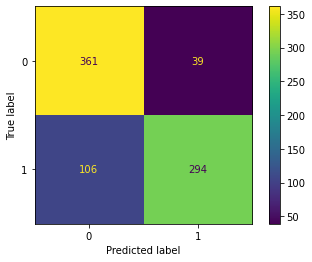

In [149]:
disp_cm_test.plot()

In [150]:
disp_cm_val = ConfusionMatrixDisplay(cm_val[38])

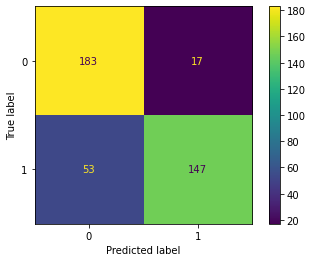

In [151]:
disp_cm_val.plot()

In [152]:
disp_cm_train = ConfusionMatrixDisplay(cm_train[38])

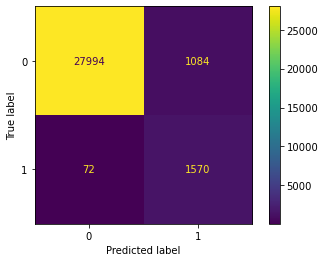

In [153]:
disp_cm_train.plot()

[0.71962890625, 0.8125651041666667, 0.8478190104166666, 0.876171875, 0.8874674479166667, 0.8925455729166667, 0.90009765625, 0.9044270833333333, 0.9042643229166667, 0.91533203125, 0.92177734375, 0.935546875, 0.9353515625, 0.9433268229166667, 0.94677734375, 0.9562174479166666, 0.95458984375, 0.95732421875, 0.9671875, 0.9633463541666667, 0.9615234375, 0.9723307291666666, 0.9755533854166667, 0.96650390625, 0.9712565104166667, 0.9786458333333333, 0.9776692708333333, 0.97783203125, 0.9419921875, 0.95771484375, 0.9708658854166666, 0.9738932291666667, 0.9735677083333333, 0.9751302083333333, 0.9688151041666667, 0.959765625, 0.9681640625, 0.9729166666666667, 0.9623697916666667, 0.9686197916666667, 0.9788411458333334, 0.97734375, 0.9782877604166667, 0.9602213541666667, 0.9741536458333333, 0.9805338541666667, 0.98203125, 0.9715169270833334, 0.9710611979166667, 0.9826822916666667, 0.9836263020833333, 0.9832356770833334, 0.9833984375, 0.9786458333333333, 0.9836263020833333, 0.9880859375, 0.979069010

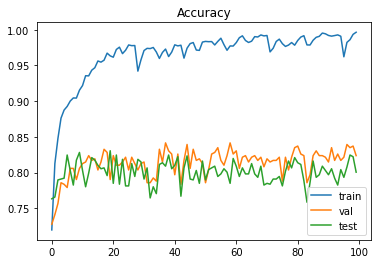

In [123]:
import matplotlib.pyplot as plt
print(accuracy_train)
plt.title("Accuracy")
plt.plot(accuracy_train, label="train")
plt.plot(accuracy_val,label="val")
plt.plot(accuracy_test, label="test")
#plt.ylim(0.90,0.94)
plt.legend()

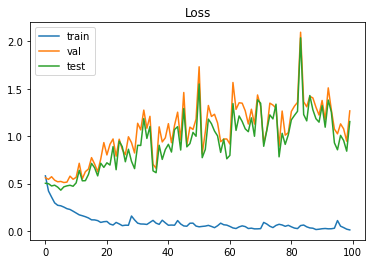

In [124]:
plt.title("Loss")
plt.plot(loss_train, label="train")
plt.plot(loss_val,label="val")
plt.plot(loss_test, label="test")
#plt.ylim(0.2,0.3)
plt.legend()

In [125]:
# Test tweet
tweet = "i finally found a way how to delete old tweets you might find it useful as well deletetweets"
# tweet = "happy mothers day to ppl"
# tweet = "about to watch these movies alone"
# tweet = "cant wait for icon this weekend and cant wait to finally get one of these tattoo"
tweet = [vocab[w] for w in tweet.split(" ")]
tweet = [0]*(seq_len - len(tweet)) + tweet
tweet = torch.LongTensor(tweet).unsqueeze(0).to(dev)
# Process tweet
model.eval()
output = model(tweet).cpu()
probabilities = F.softmax(output,1)
_,pred = output.max(1)
pred = pred[0]
print(("positive" if pred == 1 else "negative") + f" ({100*probabilities[0,pred]:.1f}%)")

negative (100.0%)


In [126]:
def predict_text_train(text, model):
    # Get predictions from model
    text = (text.unsqueeze(dim=0)).to(dev)
    yb = model(text)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset[preds[0].item()]

In [127]:
text, label = train_dataset[1]
text.shape[0]

10

In [128]:
print('Label:', train_dataset[label], ', Predicted:', predict_text_train(text, model))
true_train= train_dataset[label]
pred_train=predict_text_train(text, model)
tweets_or = "".join(list_characters)

Label: (tensor([ 6825,  6825,  6825,  6825, 31266, 32915, 26333, 25768, 35848,  9487]), tensor(1)) , Predicted: (tensor([ 6825,  6825,  6825,  6825, 31266, 32915, 26333, 25768, 35848,  9487]), tensor(1))


In [129]:
tweets_or[0:100]

'thank you user for you follow  \nuser sikh temple vandalised in in calgary wso condemns  act  \nlisten'

In [130]:
tweets_or = tweets_or.split("\n")
#tweets_or[28141]
tvalue_train=true_train[0]

In [131]:
tvalue_train

tensor([ 6825,  6825,  6825,  6825, 31266, 32915, 26333, 25768, 35848,  9487])

In [132]:
tweets_or[tvalue_train[0]]

'done watching finding dory  findingdory movie marathon adventure alimallcineplex   '

In [133]:
print('Label:', tweets_or[train_dataset[label][0][0]], ', Predicted:', tweets_or[predict_text_train(text, model)[0][0]])

Label: done watching finding dory  findingdory movie marathon adventure alimallcineplex    , Predicted: done watching finding dory  findingdory movie marathon adventure alimallcineplex   


In [135]:
def predict_text_val(text, model):
    # Get predictions from model
    text = (text.unsqueeze(dim=0)).to(dev)
    yb = model(text)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return val_dataset[preds[0].item()]

In [136]:
print('Label:', val_dataset[label], ', Predicted:', predict_text_val(text, model))
true_val= val_dataset[label]
pred_val=predict_text_val(text, model)
#tweets_or = "".join(list_characters)

Label: (tensor([ 7919, 14869,  1944,   281, 22909,  1800, 34348, 15352, 14561, 20457]), tensor(1)) , Predicted: (tensor([ 7919, 14869,  1944,   281, 22909,  1800, 34348, 15352, 14561, 20457]), tensor(1))


In [137]:
#tweets_or[0:100]

In [138]:
tvalue_val=true_val[0:]

In [139]:
tvalue_val

(tensor([ 7919, 14869,  1944,   281, 22909,  1800, 34348, 15352, 14561, 20457]),
 tensor(1))

In [140]:
tweets_or[tvalue_val[1]]

'user sikh temple vandalised in in calgary wso condemns  act  '

In [141]:
print('Label:', tweets_or[val_dataset[label][1:][0]], ', Predicted:', tweets_or[predict_text_val(text, model)[1:][0]])

Label: user sikh temple vandalised in in calgary wso condemns  act   , Predicted: user sikh temple vandalised in in calgary wso condemns  act  


In [142]:
def predict_text_test(text, model):
    # Get predictions from model
    text = (text.unsqueeze(dim=0)).to(dev)
    yb = model(text)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset[preds[0].item()]

In [143]:
print('Label:', test_dataset[label], ', Predicted:', predict_text_test(text, model))
true_test= test_dataset[label]
pred_test=predict_text_test(text, model)
#tweets_or = "".join(list_characters)

Label: (tensor([ 3031,  1307, 25352,   726, 39029, 16723,  3431, 21169, 16723,  3431]), tensor(1)) , Predicted: (tensor([ 3031,  1307, 25352,   726, 39029, 16723,  3431, 21169, 16723,  3431]), tensor(1))


In [144]:
tvalue_test=true_test[0]

In [145]:
tvalue_test

tensor([ 3031,  1307, 25352,   726, 39029, 16723,  3431, 21169, 16723,  3431])

In [146]:
tweets_or[tvalue_test[0]]

'i am thankful for my school thankful positive     '

In [147]:
print('Label:', tweets_or[test_dataset[label][0][0]], ', Predicted:', tweets_or[predict_text_test(text, model)[0][0]])

Label: i am thankful for my school thankful positive      , Predicted: i am thankful for my school thankful positive     
